# Important note before running this code
This code assumes that the data preperation notebook was executed before and hence the sql database accessed underneath, is already populated

In [7]:
# Imports
from sqlalchemy import create_engine, inspect, Table
import pandas as pd
import numpy as np
import json
import country_converter as coco
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [8]:
# Open a connection to the postgresql database
db_conn = create_engine("postgresql://student:infomdss@db_dashboard:5432/covid")

In [9]:
df = pd.read_sql('SELECT * FROM cases',db_conn)
df.head()

,iso_code,date,new_cases_per_million,new_cases_smoothed_per_million,reproduction_rate
0,ITA,2020-01-31,0.034,NaN,NaN
1,ITA,2020-02-01,0.000,NaN,NaN
2,ITA,2020-02-02,0.000,NaN,NaN
3,ITA,2020-02-03,0.000,NaN,NaN
4,ITA,2020-02-04,0.000,NaN,NaN


In [10]:
class SQL_reader:
    def __init__(self, db_conn,mainView,ISO_filter = ['NLD','JPN','ITA']):
        self.db_conn = db_conn
        self.mainView = mainView
        self.ISO_filter = ISO_filter
    def GetIsoDict(self, kpiColNames, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which reads a KPI from the SQL database for all countries specified in the ISO_filter distinctly.
        And makes them of equal length such that the Nth entry of the KPI array is the value of this KPI X days before
        the PER level of the Nth entry of the policy array, where X = daysAhead.
        The method returns a dictionary mapping the ISO code of each country to a (kpi, policy) pair for that country.
        """
        isoDict = dict()
        for iso in self.ISO_filter:
            queryP2 = ' FROM ' + self.mainView + '\nWHERE ' "iso_code = '" + iso + "';"
            policy = np.array(pd.read_sql('SELECT ' + policyColName + queryP2, self.db_conn)[policyColName])
            policy = policy[daysAhead:]
            kpis = []
            for kpiColName in kpiColNames:
                kpi = np.array(pd.read_sql('SELECT ' + kpiColName + queryP2, self.db_conn)[kpiColName])
                kpi = kpi[:-daysAhead]
                kpis.append(kpi)
            toDelete = []

            for i in range(len(policy)):
                if policy[i] == None or np.isnan(policy[i]): #Ugly code, first  condition should be dropped after data preprocessing makes sure missing values are encoded consistentl
                    toDelete.append(i)
                    continue
                for kpi in kpis:
                    if kpi[i] == None or np.isnan(kpi[i]): #Ugly code, first  condition should be dropped after data preprocessing makes sure missing values are encoded consistently
                        toDelete.append(i)
                        break
            for i in range(len(kpis)):
                kpis[i] = np.delete(kpis[i],toDelete)
            policy = np.delete(policy,toDelete)
            isoDict[iso] = (kpis,policy)
        return isoDict
    
    def FormatColumns(self, kpiColNames, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which returns a kpi, policy pair of equal length such that the Nth entry of the KPI array is the value of this KPI X days before
        the PER level of the Nth entry of the policy array, where X = daysAhead. These arrays contain the values for all countries in the ISO_filter.
        """
        isoDict = self.GetIsoDict(kpiColNames,policyColName,daysAhead)
        
        kpis = []
        for i in range(len(list(isoDict.values())[0][0])):
            kpis.append([])
        policy = []
        for k, v in isoDict.items():
            kpiParts, policyPart = v
            for i in range(len(kpiParts)):
                kpis[i].extend(kpiParts[i])
            policy.extend(policyPart)
        return kpis, policy

In [11]:
class DescriptiveRelationAnalytics:
    """
    A class designed to perform descriptive analytics for the relation between
    all kpi's and our independent variable, being the public event restrictions (PER) level
    in place (an ordinal value with 5 levels).
    """
    def __init__(self, db_conn,mainView,ISO_filter = ['NLD','JPN','ITA']):
        self.sql = SQL_reader(db_conn,mainView,ISO_filter)
    def KPI_policy_covar(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return the covariance matrix between a given kpi and the PER level X days later,
        where X = daysAhead
        NOTE TO SELF: covariance between an ordinal and ratio value might not make sense, might need to delete this function
        """
        kpis, policy = self.sql.FormatColumns([kpiColName],policyColName,daysAhead)
        kpi = kpis[0]
        covar = np.cov(kpi,policy)
        return covar
    def KPI_policy_rho(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to find and return Spearman's rank correlation coefficient, denoted as rho, 
        together with the corresponding p-value between given KPI measure and the PER level X days later, where X = daysAhead.
        """
        kpis, policy = self.sql.FormatColumns([kpiColName],policyColName,daysAhead)
        kpi = kpis[0]
        rho, p = spearmanr(kpi,policy)
        return (rho,p)
    
    def KPI_policy_plot(self, kpiColName, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method designed to plot the PER level against a given kpi X days earlier, where X = daysAhead, distinguishing between different countries.
        """
        isoDict = self.sql.GetIsoDict([kpiColName],policyColName,daysAhead)
        for iso, v in isoDict.items():
            kpis, policy = v
            kpi = kpis[0]
            plt.scatter(kpi,policy, marker = '.',alpha=0.2)
        plt.xlabel(kpiColName)
        plt.ylabel(policyColName)
        title = policyColName + ' for ' + kpiColName + ' ' + str(daysAhead) +' days before in '
        if len(self.sql.ISO_filter)==1:
            title += self.sql.ISO_filter[0]
        else:
            for iso in self.sql.ISO_filter[:-1]:
                title+= iso + ', '
            title = title[:-2]
            title += ' and ' + self.sql.ISO_filter[-1]
        plt.title(title)
        leg = [x + ' (N=' + str(len(isoDict[x][0])) + ')' for x in isoDict.keys()]
        plt.legend(leg)
        plt.yticks(np.arange(5),['No restrictions','> 1000 people','100-1000 people','10-100 people','< 10 people'])
        plt.show()

    def KPIs_policy_stats_and_plots(self, kpiColNameList, policyColName = 'event_cancellation_level', daysAhead = 14):
        """
        A method which provides and prints statistical data on the relation between a given list of KPIs and the PER level X days later, where X = daysAhead
        and plots their relation as well
        """
        for kpiName in kpiColNameList:
            print(kpiName)
            print('covariation:\n'+str(self.KPI_policy_covar(kpiName,policyColName,daysAhead)))
            rho, p = self.KPI_policy_rho(kpiName,policyColName,daysAhead)
            print('Pearson Rho: ' + str(rho) +'\t' + 'p: ' + str(p))
            self.KPI_policy_plot(kpiName,policyColName,daysAhead)
 
    
    

In [12]:
DRanalytics = DescriptiveRelationAnalytics(db_conn,'all_relevant')

In [13]:
DRanalytics.KPI_policy_rho('reproduction_rate')

(0.07143628491233256, 0.00014231919404300518)

In [14]:
kpis = ['new_cases_smoothed_per_million','reproduction_rate','icu_patients_per_million','hosp_patients_per_million','weekly_icu_admissions_per_million',
        'people_fully_vaccinated_per_hundred', 'total_boosters_per_hundred','new_vaccinations_smoothed_per_million']

new_cases_smoothed_per_million
covariation:
[[ 4.70916605e+05 -8.23436086e+01]
 [-8.23436086e+01  2.61164199e+00]]
Pearson Rho: 0.10938338096778485	p: 4.0490404445103266e-09


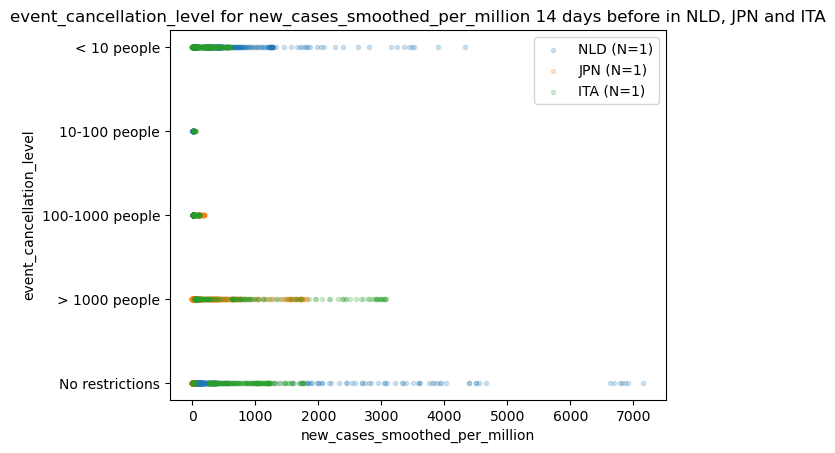

reproduction_rate
covariation:
[[0.14871947 0.05020592]
 [0.05020592 2.59481111]]
Pearson Rho: 0.07143628491233256	p: 0.00014231919404300518


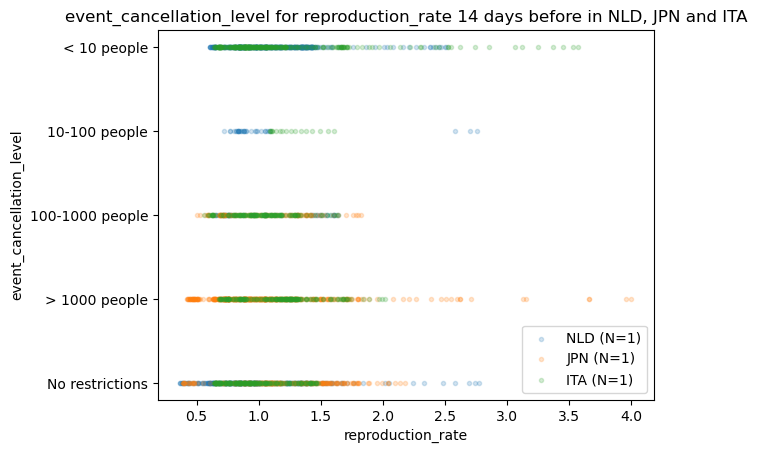

icu_patients_per_million
covariation:
[[322.05353933  19.33338846]
 [ 19.33338846   2.9950903 ]]
Pearson Rho: 0.5663038932438994	p: 1.8150093839142477e-166


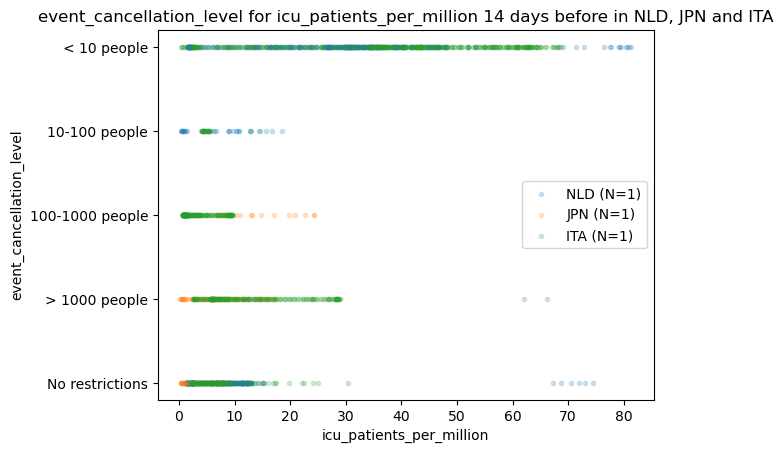

hosp_patients_per_million
covariation:
[[2.03183747e+04 8.01201472e+01]
 [8.01201472e+01 2.99583286e+00]]
Pearson Rho: 0.24296233874762563	p: 1.0248692236166646e-27


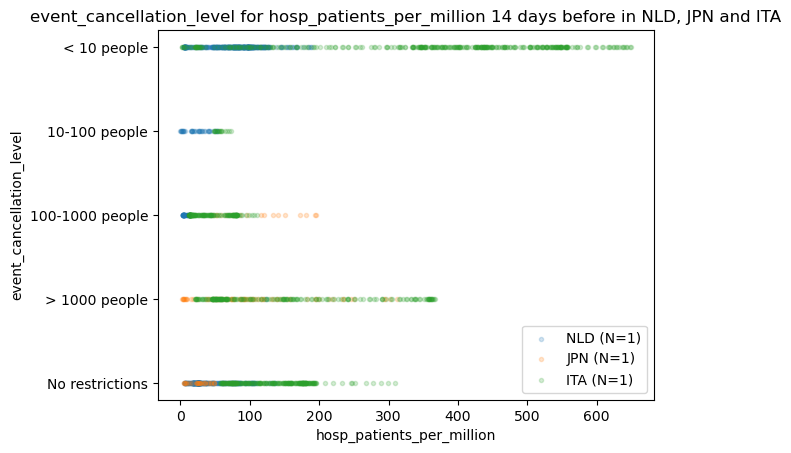

weekly_icu_admissions_per_million
covariation:
[[50.11942126  9.14842769]
 [ 9.14842769  3.34928714]]
Pearson Rho: 0.6758416853776232	p: 6.150805717449221e-174


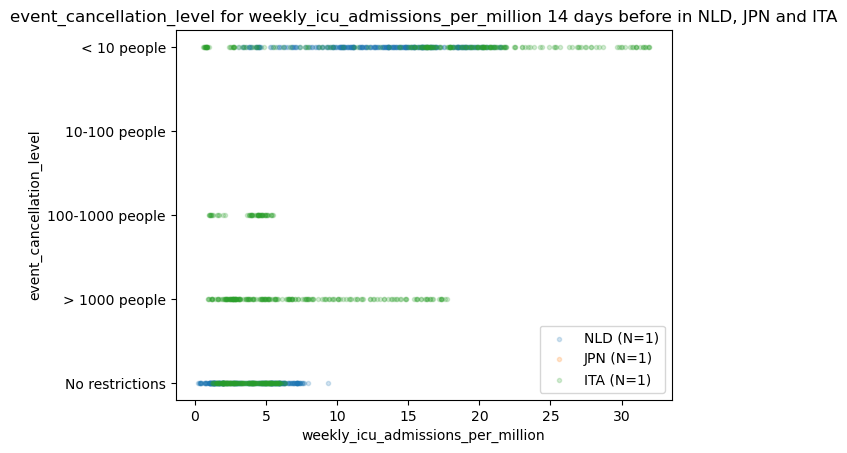

people_fully_vaccinated_per_hundred
covariation:
[[941.62743355 -28.48965399]
 [-28.48965399   1.63093294]]
Pearson Rho: -0.6512826665108706	p: 4.392469817653442e-156


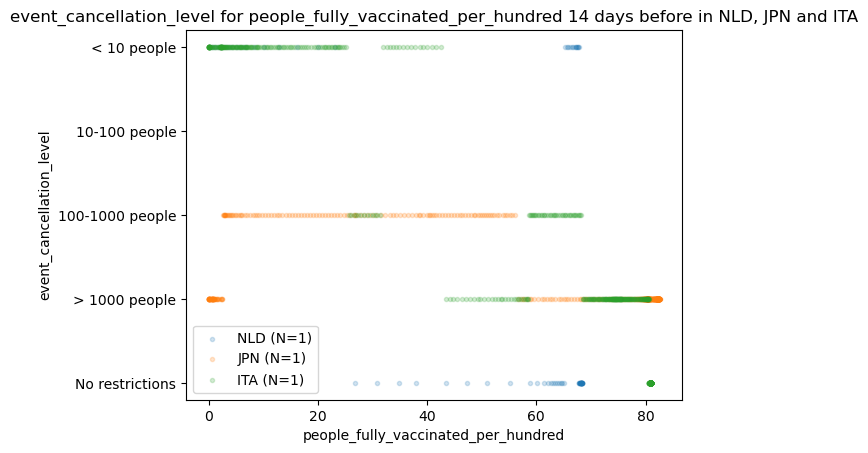

total_boosters_per_hundred
covariation:
[[ 8.28733968e+02 -8.07145927e+00]
 [-8.07145927e+00  4.29651778e-01]]
Pearson Rho: -0.5115135627318119	p: 1.0341193455654232e-50


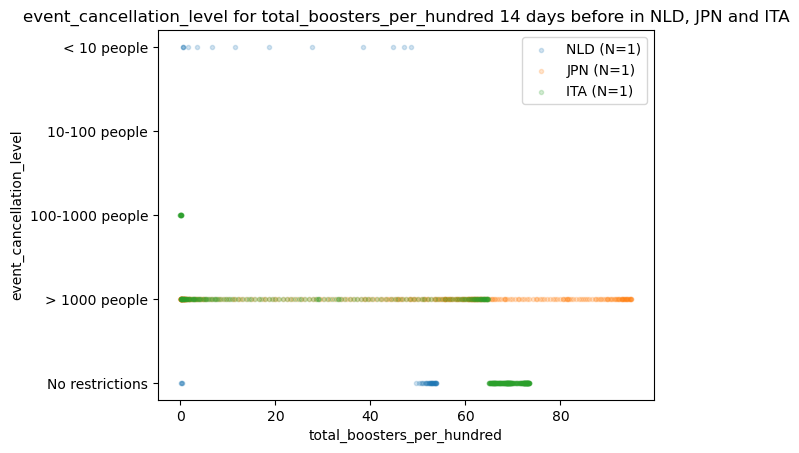

new_vaccinations_smoothed_per_million
covariation:
[[1.27830128e+07 1.59615475e+03]
 [1.59615475e+03 2.26862159e+00]]
Pearson Rho: 0.4600453423769276	p: 4.95511003393207e-97


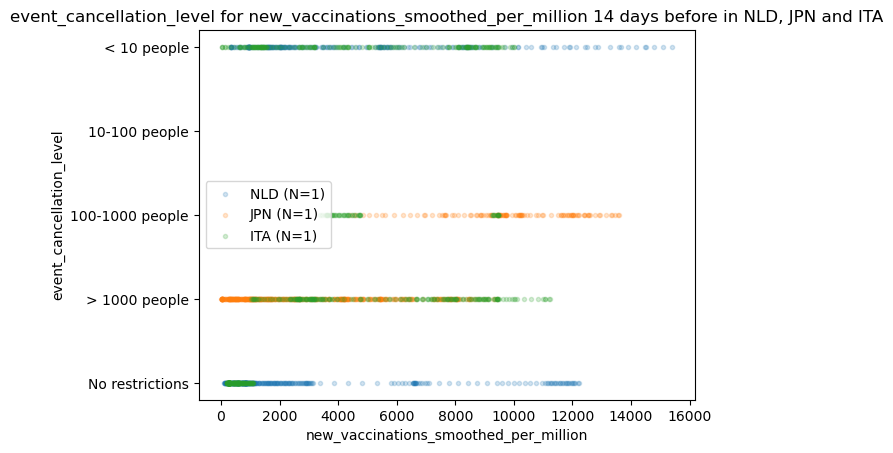

In [15]:

DRanalytics.KPIs_policy_stats_and_plots(kpis)

# Towards predictive analytics

In [16]:
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.model_selection import train_test_split

In [17]:
class MajorityBaseline:
    def __init__(self):
        self.choice = 0
    def fit(self,X,Y):
        N = len(np.unique(Y))
        Count = []
        for i in range(N):
            Count.append(0)
        for y in Y:
            for i in range(N):
                if y == i:
                    Count[i] += 1
                    break
        maxCount = max(Count)
        print(Count)
        print(maxCount)
        self.choice = [i for i in range(len(Count)) if Count[i]==maxCount][0]
    def predict(self, X):
        return np.array([self.choice for x in X])
    def score(self, X, Y):
        right = 0
        Y_hat = self.predict(X)
        for i in range(len(Y)):
            if Y_hat[i] == Y[i]:
                right += 1
        return right/len(Y)

In [18]:
class PredictiveAnalytics:
    def __init__(self, db_conn,mainView, selectedKPIs, ISO_filter = ['NLD','JPN','ITA'], policyColName = 'event_cancellation_level', daysAhead = 14):
        self.sql = SQL_reader(db_conn,mainView,ISO_filter)
        self.KPIs = selectedKPIs
        X, Y = self.sql.FormatColumns(self.KPIs,policyColName,daysAhead)
        X =np.array(X)
        Y = np.array(Y)
        
        M = []
        S = []
        for x in X:
            M.append([np.mean(x)])
            S.append([np.std(x,ddof=1)])
        M = np.array(M)
        S = np.array(S)
        X = ((X - M)/S+1)/2
        X=X.T

        
        self.X = X
        self.Y = Y
        
    def getMeanAndSD(kpi):
        m = np.mean(kpi)
        s = np.std(kpi,ddof=1)
        return m,s
    
    def PredictKNN(self, X, k = 5):
        knn = KNC(n_neighbors = k)
        knn.fit(self.X, self.Y)
        return knn.predict(X)
    
    def TestModels(self, modelDict):
        # Split into training and test set
        X_train, X_test, Y_train, Y_test = train_test_split(self.X, self.Y, test_size = 0.2, random_state=42)
        scoreDict = dict()
        for key, value in modelDict.items():
            value.fit(X_train, Y_train)
            scoreDict[key] = value.score(X_test,Y_test)
        return scoreDict
    



In [19]:
PrAn = PredictiveAnalytics(db_conn,'all_relevant',kpis)

In [20]:
N = [0,0,0,0,0]
for y in PrAn.Y:
    for i in range(5):
        if y == i:
            N[i] += 1
            break
print('Y data distribution:')
for i in range(5):
    print(str(i) + ': ' + str(N[i]))

Y data distribution:
0: 235
1: 174
2: 12
3: 0
4: 13


In [21]:

modelDict = dict()
modelDict['knn model (k=1)'] =  KNC(n_neighbors = 1)
modelDict['knn model (k=2)'] =  KNC(n_neighbors = 2)
modelDict['knn model (k=5)'] = KNC(n_neighbors = 5)
modelDict['knn model (k=10)'] = KNC(n_neighbors = 10)
mb = MajorityBaseline()
modelDict['Majority baseline'] = mb
x = PrAn.TestModels(modelDict)
print(x)

[183, 144, 9, 0]
183
{'knn model (k=1)': 0.9770114942528736, 'knn model (k=2)': 0.9885057471264368, 'knn model (k=5)': 0.9885057471264368, 'knn model (k=10)': 0.9770114942528736, 'Majority baseline': 0.5977011494252874}


In [22]:
809/(581+283+230+47+809)

0.4148717948717949

In [23]:
mb.choice

0